#Лабораторная работа №2
Задание:
Взять KNN из Sc-learn.  Прочитать пример https://pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/ По аналогии проработать два своих класса желательно разноплановых.

За основу взят материал отсюда:

https://pyimagesearch.com/2021/04/17/your-first-image-classifier-using-k-nn-to-classify-images/

https://www.kaggle.com/datasets/pavansanagapati/images-dataset

In [38]:
# import the necessary packages
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyimagesearch.preprocessing import SimplePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader
from imutils import paths
import matplotlib.pyplot as plt
import yaml
import cv2

In [2]:
!tree --filelimit 20

.
├── 2_knn.ipynb
├── config.yml
├── dataset
│   ├── horses  [202 entries exceeds filelimit, not opening dir]
│   └── human  [202 entries exceeds filelimit, not opening dir]
├── image_for_test
│   └── horses
│       └── image.png
└── pyimagesearch
    ├── datasets
    │   ├── __init__.py
    │   ├── __pycache__
    │   │   ├── __init__.cpython-311.pyc
    │   │   └── simpledatasetloader.cpython-311.pyc
    │   └── simpledatasetloader.py
    └── preprocessing
        ├── __init__.py
        ├── __pycache__
        │   ├── __init__.cpython-311.pyc
        │   └── simplepreprocessor.cpython-311.pyc
        └── simplepreprocessor.py

11 directories, 11 files


In [23]:
args = yaml.safe_load(open("./config.yml"))

In [24]:
# grab the list of images that we'll be describing
imagePaths = list(paths.list_images(args['dataset']))
print(f"В обучающем наборе: {len(imagePaths)} изображения")

# initialize the image preprocessor, load the dataset from disk,
# and reshape the data matrix
w = 128
h = 128

sp = SimplePreprocessor(w, h)
sdl = SimpleDatasetLoader(preprocessors=[sp])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.reshape((data.shape[0], w*h*3))

# show some information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB".format(
	data.nbytes / (1024 * 1024.0)))

В обучающем наборе: 404 изображения
[INFO] features matrix: 18.9MB


In [25]:
# encode the labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.2, random_state=42, stratify=labels)

In [26]:
# train and evaluate a k-NN classifier on the raw pixel intensities
model = KNeighborsClassifier(n_neighbors=args["neighbors"],
	n_jobs=args["jobs"])
model.fit(trainX, trainY)
print(classification_report(testY, model.predict(testX),
	target_names=le.classes_))

              precision    recall  f1-score   support

      horses       0.67      0.98      0.79        41
       human       0.95      0.50      0.66        40

    accuracy                           0.74        81
   macro avg       0.81      0.74      0.72        81
weighted avg       0.81      0.74      0.72        81



In [27]:
from sklearn.metrics import accuracy_score

print(f"Accuracy score: {accuracy_score(testY, model.predict(testX)):.4f}")

Accuracy score: 0.7407


# Проверка на рандомном изображении из интернета

In [35]:
img_path = "image_for_test/horses/image.png"

sp = SimplePreprocessor(w, h)
sdl = SimpleDatasetLoader(preprocessors=[sp])

img = cv2.imread(img_path)
img = sp.preprocess(img)
# img = img.reshape((1, w*h*3))

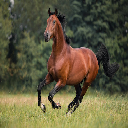

In [59]:
import tensorflow as tf

# Посмотрим на наше проверочное изображение
tf.keras.preprocessing.image.load_img(img_path, target_size=(w,h,3))

In [29]:
model_pred = model.predict(img)
pred = le.inverse_transform(model_pred)[0]
print(f"Predicted class: {pred}")

Predicted class: horses


In [30]:
distances, indices = model.kneighbors(img, n_neighbors=5)
indices = indices[0]
print("Индексы ближайших изображений:", indices)

Индексы ближайших изображений: [137  22 274  96 275]


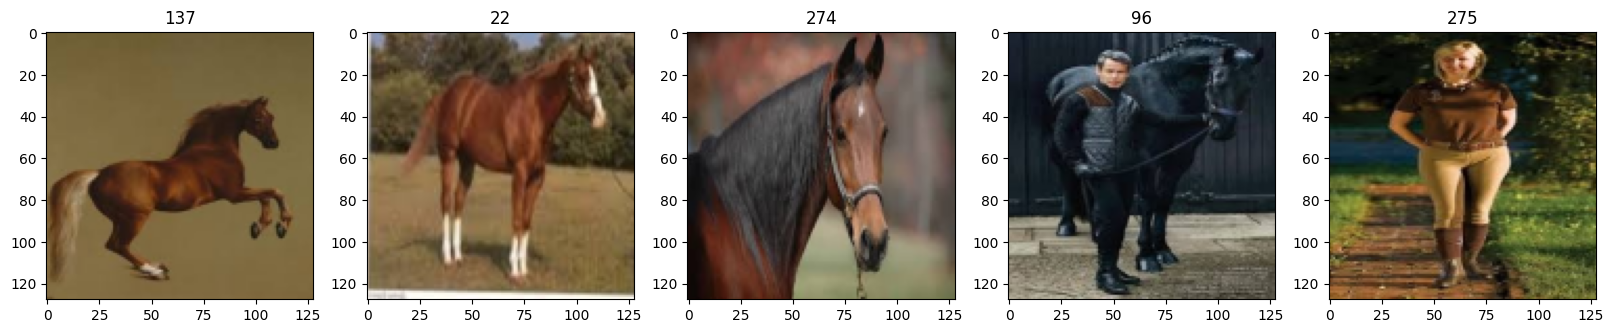

In [54]:
# Дополнительно: выведем изображения, которые являются ближайшими к нашему тестовому изображению
fig, ax = plt.subplots(ncols=len(indices), figsize=(20,20))
for idx in range(len(indices)):
    img_array = trainX[indices[idx]].reshape(w,h,3)
    image_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    ax[idx].imshow(image_bgr)
    ax[idx].title.set_text(indices[idx])